In [2]:
import os
import time
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, svm, tree, ensemble, neighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import lightgbm as lgbm

## Plotting methods

In [3]:
def plotCurve(y_test, y_pred, beginInd=0, endInd=500):
    plt.figure(figsize=(15,5))
    y_test_sorted, y_pred_sorted = zip(*sorted(zip(y_test.to_list(), y_pred.tolist())))
    y_test_sorted, y_pred_sorted = y_test_sorted[beginInd:endInd], y_pred_sorted[beginInd:endInd]

    plt.plot([i for i in range(len(y_test_sorted))], y_test_sorted, color = 'magenta', label="True", linewidth = 3)
    plt.scatter([i for i in range(len(y_test_sorted))], y_pred_sorted, color = 'green', label="Prediction")
    plt.legend()
    plt.show()

In [4]:
def plot_histo(y_test, y_pred, nbars=1000, width = 0.02):
    maxValue=y_test.max()
    minValue=y_test.min()
    step = (maxValue-minValue)/nbars

    y_test_count=[0 for _ in range(nbars)]
    y_pred_count=[0 for _ in range(nbars)]
    for i in range(len(y_test)):
        ytestInd = int(y_test[i] // step)
        ypredInd = int(y_pred[i] // step)
        y_pred_count[ypredInd] += 1
        y_test_count[ytestInd] += 1

    xValues = [x*step+minValue for x in range(nbars)]
    plt.bar(xValues, y_test_count, label="True", width=width, color = 'magenta')
    plt.bar(np.array(xValues) + width, y_pred_count, label="Prediction", width=width, color = 'green')
    plt.legend()

In [5]:
def plotGridResults(logreg_cv, x_axis_prec=5):
    nbrParam = len(logreg_cv.cv_results_["params"])
    nSplits = logreg_cv.n_splits_
    scores = [[] for i in range(nbrParam)]
    for i in range(nbrParam):
        for j in range(nSplits):
            scores[i].append(logreg_cv.cv_results_["split"+str(j)+"_test_score"][i])

    labels = []
    for param in logreg_cv.cv_results_["params"]:
        for name, value in param.items():
            if type(value) == str:
                labels.append(value)
            else:
                labels.append(str(round(value,x_axis_prec)))

    plt.boxplot(scores, labels=labels)

## Data loading

In [6]:
fullData = pd.read_csv("../HGS/clean_dataset_v3.csv", sep=",")

In [7]:
fullData = fullData.drop(columns=["S7", "S13"])

In [8]:
def model_rapport(name, model, y_test, x_test, precision = 5):
    y_pred = model.predict(x_test)
    r2modelScore = round(r2_score(y_test, y_pred), precision)
    print(name, "--------------------------------------")
    print("R2:", r2modelScore)
    print("MSE:", round(mean_squared_error(y_test, y_pred), precision))
    print("RMSE:", round(mean_squared_error(y_test, y_pred, squared=False), precision))
    print("MAE:", round(mean_absolute_error(y_test, y_pred), precision))
    return r2modelScore

## Model tests methods

In [9]:
def model_cv_rapport(model, x, y: np.array, cv=5, precision = 8):
    #making sure data is standarized
    pipe = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('clf', model)
    ])
    score = cross_validate(pipe, x, y, cv=cv,
                           scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
                           verbose=10,
                           n_jobs=-1)
    print("MAE: ", round(-score["test_neg_mean_absolute_error"].mean(), precision))
    print("RMSE: ", round(-score["test_neg_root_mean_squared_error"].mean(), precision))
    print("R2: ", round(score["test_r2"].mean(), precision))

In [10]:
"""
 grid={"C":np.logspace(-3,3,7),
          "kernel":kernels,
          "epsilon":np.logspace(-3,3,7),
          "gamma": np.logspace(-3,3,7)}
"""

def grid_search(grid, model, x_train, y_train, cv=5, verbose=10):
    #making sure data is standarized
    pipe = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('clf', model)
    ])

    #modifying grid params to match pipeline
    newGrid = [{}]
    for key, item in grid.items():
        newGrid[0]["clf__"+key] = item

    logreg_cv=GridSearchCV(pipe,param_grid=newGrid,cv=cv, verbose=verbose, scoring="r2")
    logreg_cv.fit(x_train,y_train)
    print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
    print("accuracy :",logreg_cv.best_score_)
    return logreg_cv

## Data sampling and Train-Test splitting

In [11]:
chunkData = fullData.sample(10000, random_state=123456)
chunkData = chunkData.drop(columns=["instance_name"])

#I shouldn't standarize the whole set
#chunkData = pd.DataFrame(preprocessing.StandardScaler().fit_transform(chunkData), columns=colNames)
chunkData.head()

,cost,S1,S2,S3,S4,S5,S6,S8,S9,S10,S11,S12,S14,S15,S16,S17,S18
12800051,14483,131.402,99.7370,0.0847,0.0643,559.667,299.700,448.750,0.3663,0.0872,805.167,0.3704,0.2457,637.502,345.401,2.2111,4.1302
5483954,10406,137.274,64.4632,0.1157,0.0859,454.500,100.664,293.000,0.2868,0.1268,525.600,0.2123,0.0329,249.455,352.032,1.8974,3.8180
10788912,20900,162.031,93.7861,0.0574,0.0474,973.900,281.018,759.600,0.3692,0.0821,1421.000,0.3636,0.2727,593.597,437.968,3.0000,4.7000
8346315,21353,230.727,149.5370,0.1096,0.0606,803.167,322.533,641.167,0.3607,0.1160,1117.000,0.3704,0.2457,724.450,496.813,2.2111,3.4688
134772,14324,266.923,133.4720,0.2667,0.2520,473.333,171.891,348.583,0.3057,0.1183,592.333,0.3704,0.2457,443.784,472.126,2.2111,2.9479


In [12]:
y = chunkData.cost
x = chunkData.drop(columns=["cost"])

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
#normalizing data, only according to train data mean and variance
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

y_scaler = preprocessing.StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

ValueError: Expected 2D array, got 1D array instead:
array=[22768. 22931. 20255. ... 20016. 24223. 10936.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Linear regression

In [ ]:
#Setting models
models = {
    "Linear": linear_model.LinearRegression(),
    "ElasticNet": linear_model.ElasticNet(alpha=0.7, l1_ratio=0.5, max_iter=1000, tol=1e-4),
    "Ridge": linear_model.Ridge(alpha=0.5, max_iter=1000, tol=1e-4)
}

In [ ]:
#Training model
for _, model in models.items():
    model.fit(x_train, y_train)

In [ ]:
#stats
for name, model in models.items():
    model_rapport(name, model, y_test=y_test, x_test=x_test, precision=10)

Linear --------------------------------------
r2_score: 0.9377995496
mean squared error: 0.0621367255
root mean squared error: 0.2492723922
mean absolute error: 0.198005403
ElasticNet --------------------------------------
r2_score: 0.626129432
mean squared error: 0.3734875348
root mean squared error: 0.6111362653
mean absolute error: 0.5127721353
Ridge --------------------------------------
r2_score: 0.9377971366
mean squared error: 0.0621391361
root mean squared error: 0.2492772274
mean absolute error: 0.1980158723


Looks like Ridge is the best model with basic parameters

### Hyperparameters - Linear Regression

#### Alpha parameter

Fitting 5 folds for each of 9 candidates, totalling 45 fits
tuned hyperparameters :(best parameters)  {'alpha': 0.1}
accuracy : 0.9851086791107416


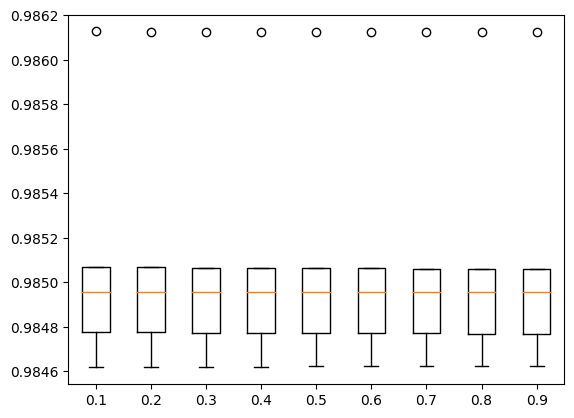

In [ ]:
alphaGrid = {"alpha": [i/10.0 for i in range(1, 10)]}
results = grid_search(alphaGrid, linear_model.Ridge(), x, y)
plotGridResults(results)

#### max_iter param

Fitting 5 folds for each of 5 candidates, totalling 25 fits
tuned hyperparameters :(best parameters)  {'max_iter': 10}
accuracy : 0.985105696382903


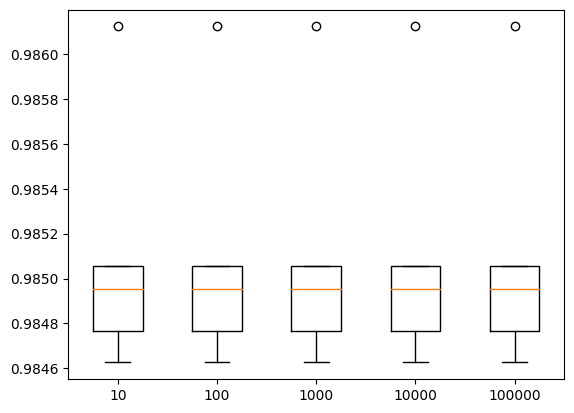

In [ ]:
iterGrid = {"max_iter": np.logspace(1, 5, 5, dtype=int)}
results = grid_search(iterGrid, linear_model.Ridge(), x, y)
plotGridResults(results)

Comments : alpha and max_iter have no impact on the models

### Best linear regression evaluation

In [ ]:
model = linear_model.Ridge()
model_cv_rapport(model, x, y)

## KNN Regression

In [ ]:
model = neighbors.KNeighborsRegressor(
    n_neighbors=10,
    weights="uniform",
    p=2,
    metric="minkowski")

In [ ]:
model.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [ ]:
model_rapport("KNN", model, y_test, x_test)

KNN --------------------------------------
r2_score: 0.99653
mean squared error: 0.00344
root mean squared error: 0.05862
mean absolute error: 0.03154


0.99653

### Hyperparameters - KNN

In [ ]:
model = neighbors.KNeighborsRegressor()
grid = {
    "n_neighbors": [i for i in range(1, 10)],
    "weights": ["uniform", "distance"],
    "metric" : ["cityblock","cosine", "euclidean", "l1", "l2", "manhattan","nan_euclidean"]
}
grid_search(grid, model, x, y, verbose=1)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
[CV 1/5; 1/126] START clf__metric=cityblock, clf__n_neighbors=1, clf__weights=uniform
[CV 1/5; 1/126] END clf__metric=cityblock, clf__n_neighbors=1, clf__weights=uniform;, score=0.999 total time=   0.2s
[CV 2/5; 1/126] START clf__metric=cityblock, clf__n_neighbors=1, clf__weights=uniform
[CV 2/5; 1/126] END clf__metric=cityblock, clf__n_neighbors=1, clf__weights=uniform;, score=0.998 total time=   0.0s
[CV 3/5; 1/126] START clf__metric=cityblock, clf__n_neighbors=1, clf__weights=uniform
[CV 3/5; 1/126] END clf__metric=cityblock, clf__n_neighbors=1, clf__weights=uniform;, score=0.998 total time=   0.0s
[CV 4/5; 1/126] START clf__metric=cityblock, clf__n_neighbors=1, clf__weights=uniform
[CV 4/5; 1/126] END clf__metric=cityblock, clf__n_neighbors=1, clf__weights=uniform;, score=0.998 total time=   0.0s
[CV 5/5; 1/126] START clf__metric=cityblock, clf__n_neighbors=1, clf__weights=uniform
[CV 5/5; 1/126] END clf__metric=cityblo

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf', KNeighborsRegressor())]),
             param_grid=[{'clf__metric': ['cityblock', 'cosine', 'euclidean',
                                          'l1', 'l2', 'manhattan',
                                          'nan_euclidean'],
                          'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'clf__weights': ['uniform', 'distance']}],
             scoring='r2', verbose=10)

### Best KNN eval

In [ ]:
model = neighbors.KNeighborsRegressor(
    n_neighbors=4,
    weights="distance",
    metric="cityblock")
model_cv_rapport(model, x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s


MAE:  103.01222702
RMSE:  179.00908658
R2:  0.99884193


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


## Support Vector Regression

In [ ]:
#Setting model
model = svm.SVR(kernel="rbf", gamma="scale", epsilon=0.1, C=1.0)
model.fit(x_train, y_train)

SVR()

In [ ]:
model_rapport("SVR", model, y_test, x_test)

SVR --------------------------------------
r2_score: 0.99847
mean squared error: 0.00154
root mean squared error: 0.03921
mean absolute error: 0.03206


0.99847

### Hyperparameters - SVR

#### kernel param

In [ ]:
#Testing kernel parameter
grid={#"C":np.logspace(-3,3,7),
      "kernel": ["linear", "poly", "rbf", "sigmoid"]}
      #"epsilon":np.logspace(-3,3,7),
      #"gamma": np.logspace(-3,3,7)}
model=svm.SVR()
results = grid_search(grid, model, x, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START clf__kernel=linear..........................................
[CV 1/5; 1/4] END ...........clf__kernel=linear;, score=0.930 total time=   2.7s
[CV 2/5; 1/4] START clf__kernel=linear..........................................
[CV 2/5; 1/4] END ...........clf__kernel=linear;, score=0.937 total time=   2.6s
[CV 3/5; 1/4] START clf__kernel=linear..........................................
[CV 3/5; 1/4] END ...........clf__kernel=linear;, score=0.929 total time=   2.6s
[CV 4/5; 1/4] START clf__kernel=linear..........................................
[CV 4/5; 1/4] END ...........clf__kernel=linear;, score=0.929 total time=   2.7s
[CV 5/5; 1/4] START clf__kernel=linear..........................................
[CV 5/5; 1/4] END ...........clf__kernel=linear;, score=0.929 total time=   2.7s
[CV 1/5; 2/4] START clf__kernel=poly............................................
[CV 1/5; 2/4] END .............clf__kernel=poly;,

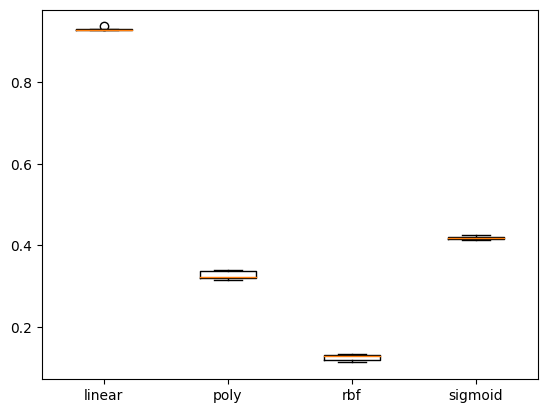

In [ ]:
plotGridResults(results)

#### C param

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5; 1/7] START clf__C=0.1..................................................
[CV 1/5; 1/7] END ...................clf__C=0.1;, score=0.720 total time=   4.0s
[CV 2/5; 1/7] START clf__C=0.1..................................................
[CV 2/5; 1/7] END ...................clf__C=0.1;, score=0.728 total time=   3.3s
[CV 3/5; 1/7] START clf__C=0.1..................................................
[CV 3/5; 1/7] END ...................clf__C=0.1;, score=0.724 total time=   3.3s
[CV 4/5; 1/7] START clf__C=0.1..................................................
[CV 4/5; 1/7] END ...................clf__C=0.1;, score=0.717 total time=   4.4s
[CV 5/5; 1/7] START clf__C=0.1..................................................
[CV 5/5; 1/7] END ...................clf__C=0.1;, score=0.717 total time=   3.8s
[CV 1/5; 2/7] START clf__C=0.46415888336127786..................................
[CV 1/5; 2/7] END ...clf__C=0.46415888336127786;,

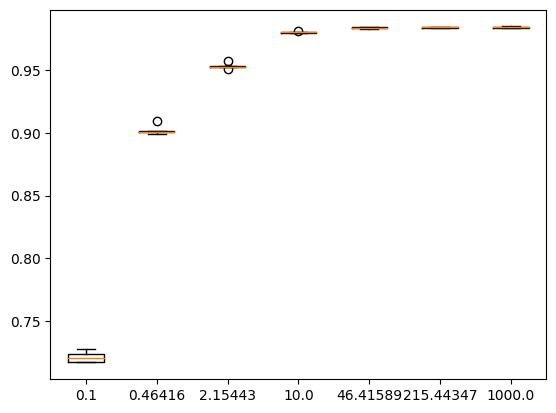

In [ ]:
#Testing C parameter
grid={"C":np.logspace(-1,3,7)}
      #"kernel": ["rbf"]
      #"epsilon":np.logspace(-3,3,7),
      #"gamma": np.logspace(-3,3,7)}
model=svm.SVR(kernel="linear")
Cresults = grid_search(grid, model, x, y)
plotGridResults(Cresults)

#### Epsilon param

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5; 1/7] START clf__epsilon=0.001..........................................
[CV 1/5; 1/7] END ...........clf__epsilon=0.001;, score=0.930 total time=   3.8s
[CV 2/5; 1/7] START clf__epsilon=0.001..........................................
[CV 2/5; 1/7] END ...........clf__epsilon=0.001;, score=0.937 total time=   2.7s
[CV 3/5; 1/7] START clf__epsilon=0.001..........................................
[CV 3/5; 1/7] END ...........clf__epsilon=0.001;, score=0.929 total time=   2.7s
[CV 4/5; 1/7] START clf__epsilon=0.001..........................................
[CV 4/5; 1/7] END ...........clf__epsilon=0.001;, score=0.929 total time=   5.3s
[CV 5/5; 1/7] START clf__epsilon=0.001..........................................
[CV 5/5; 1/7] END ...........clf__epsilon=0.001;, score=0.929 total time=   4.8s
[CV 1/5; 2/7] START clf__epsilon=0.01...........................................
[CV 1/5; 2/7] END ............clf__epsilon=0.01;,

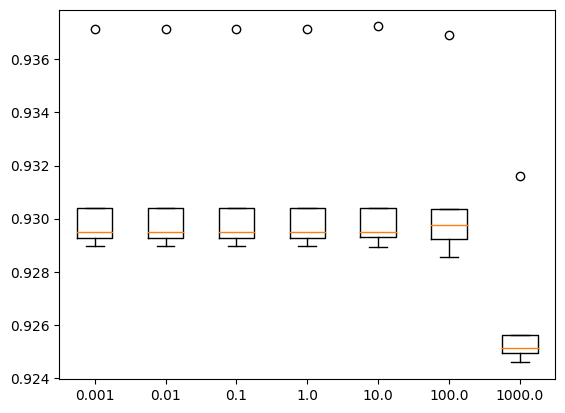

In [ ]:
#Testing eps parameter
grid={#"C":np.logspace(-1,3,7)}
      #"kernel": ["rbf"]
      "epsilon":np.logspace(-3,3,7)}
      #"gamma": np.logspace(-3,3,7)}
model=svm.SVR(kernel="linear")
Epsresults = grid_search(grid, model, x, y)
plotGridResults(Epsresults)

#### Best hyperparameters

In [ ]:
#Setting model
model = svm.SVR(kernel="linear", epsilon=10, C=1000)
model.fit(x_train, y_train)
model_rapport("Best SVR", model, y_test, x_test)

Best SVR --------------------------------------
r2_score: 0.98507
mean squared error: 424396.28249
root mean squared error: 651.45705
mean absolute error: 493.10488


0.98507

After testing hyperparameters, the best seems to be kernel=rbf, espilon=0.001, gamma=0.01, C=10.
r2 score = 0.99975

### Best SVR eval

In [ ]:
model = svm.SVR(kernel="linear", epsilon=10, C=1000)
model_cv_rapport(model, x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.1s remaining:   31.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.5s remaining:   14.3s


MAE:  502.95113961
RMSE:  662.89101269
R2:  0.98414775


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s finished


## Decision tree regression

In [ ]:
treeModel = tree.DecisionTreeRegressor(criterion="squared_error", #"absolute_error", #"friedman_mse",
                                   max_depth=None,
                                   max_features=None,
                                   min_samples_leaf=1,
                                   min_samples_split=2)
treeModel.fit(x_train, y_train)
value = model_rapport("Decision tree", treeModel, y_test=y_test, x_test=x_test)

Decision tree --------------------------------------
r2_score: 0.99836
mean squared error: 46746.8355
root mean squared error: 216.21017
mean absolute error: 112.4455


### Hyperparameters - Decision Tree
#### criterion param

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START clf__criterion=squared_error................................
[CV 1/5; 1/3] END .clf__criterion=squared_error;, score=0.998 total time=   0.1s
[CV 2/5; 1/3] START clf__criterion=squared_error................................
[CV 2/5; 1/3] END .clf__criterion=squared_error;, score=0.998 total time=   0.0s
[CV 3/5; 1/3] START clf__criterion=squared_error................................
[CV 3/5; 1/3] END .clf__criterion=squared_error;, score=0.998 total time=   0.0s
[CV 4/5; 1/3] START clf__criterion=squared_error................................
[CV 4/5; 1/3] END .clf__criterion=squared_error;, score=0.998 total time=   0.0s
[CV 5/5; 1/3] START clf__criterion=squared_error................................
[CV 5/5; 1/3] END .clf__criterion=squared_error;, score=0.998 total time=   0.1s
[CV 1/5; 2/3] START clf__criterion=absolute_error...............................
[CV 1/5; 2/3] END clf__criterion=absolute_error;,

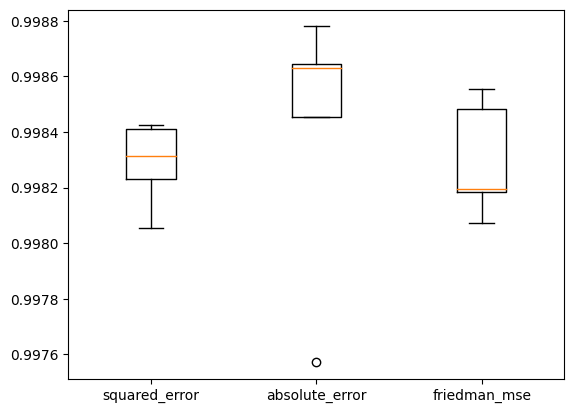

In [ ]:
#Testing criterion parameter
grid={"criterion": ["squared_error", "absolute_error", "friedman_mse"]}
model=tree.DecisionTreeRegressor()
Critresults = grid_search(grid, model, x, y)
plotGridResults(Critresults)

#### max_depth param

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START clf__max_depth=1...........................................
[CV 1/5; 1/16] END ............clf__max_depth=1;, score=0.827 total time=   0.0s
[CV 2/5; 1/16] START clf__max_depth=1...........................................
[CV 2/5; 1/16] END ............clf__max_depth=1;, score=0.829 total time=   0.0s
[CV 3/5; 1/16] START clf__max_depth=1...........................................
[CV 3/5; 1/16] END ............clf__max_depth=1;, score=0.840 total time=   0.0s
[CV 4/5; 1/16] START clf__max_depth=1...........................................
[CV 4/5; 1/16] END ............clf__max_depth=1;, score=0.845 total time=   0.0s
[CV 5/5; 1/16] START clf__max_depth=1...........................................
[CV 5/5; 1/16] END ............clf__max_depth=1;, score=0.841 total time=   0.0s
[CV 1/5; 2/16] START clf__max_depth=2...........................................
[CV 1/5; 2/16] END ............clf__max_depth=2;

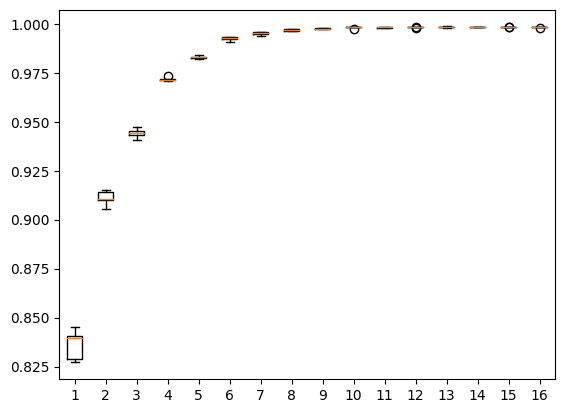

In [ ]:
grid={"max_depth":[i for i in range(1, 17)]}
model=tree.DecisionTreeRegressor()
results = grid_search(grid, model, x, y)
plotGridResults(results)

#### max_features param

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START clf__max_features=0.1......................................
[CV 1/5; 1/10] END .......clf__max_features=0.1;, score=0.983 total time=   0.0s
[CV 2/5; 1/10] START clf__max_features=0.1......................................
[CV 2/5; 1/10] END .......clf__max_features=0.1;, score=0.987 total time=   0.0s
[CV 3/5; 1/10] START clf__max_features=0.1......................................
[CV 3/5; 1/10] END .......clf__max_features=0.1;, score=0.991 total time=   0.0s
[CV 4/5; 1/10] START clf__max_features=0.1......................................
[CV 4/5; 1/10] END .......clf__max_features=0.1;, score=0.991 total time=   0.0s
[CV 5/5; 1/10] START clf__max_features=0.1......................................
[CV 5/5; 1/10] END .......clf__max_features=0.1;, score=0.981 total time=   0.0s
[CV 1/5; 2/10] START clf__max_features=0.2......................................
[CV 1/5; 2/10] END .......clf__max_features=0.2;

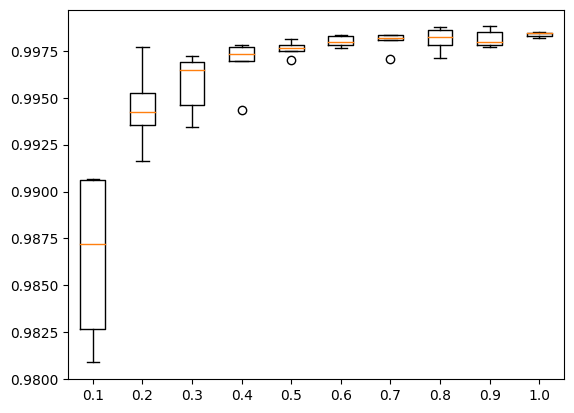

In [ ]:
grid={"max_features":[i/10.0 for i in range(1, 11)]}
model=tree.DecisionTreeRegressor()
results = grid_search(grid, model, x, y)
plotGridResults(results)

#### min_samples_leaf param

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START clf__min_samples_leaf=1.....................................
[CV 1/5; 1/9] END ......clf__min_samples_leaf=1;, score=0.999 total time=   0.1s
[CV 2/5; 1/9] START clf__min_samples_leaf=1.....................................
[CV 2/5; 1/9] END ......clf__min_samples_leaf=1;, score=0.998 total time=   0.1s
[CV 3/5; 1/9] START clf__min_samples_leaf=1.....................................
[CV 3/5; 1/9] END ......clf__min_samples_leaf=1;, score=0.998 total time=   0.0s
[CV 4/5; 1/9] START clf__min_samples_leaf=1.....................................
[CV 4/5; 1/9] END ......clf__min_samples_leaf=1;, score=0.998 total time=   0.1s
[CV 5/5; 1/9] START clf__min_samples_leaf=1.....................................
[CV 5/5; 1/9] END ......clf__min_samples_leaf=1;, score=0.998 total time=   0.0s
[CV 1/5; 2/9] START clf__min_samples_leaf=2.....................................
[CV 1/5; 2/9] END ......clf__min_samples_leaf=2;,

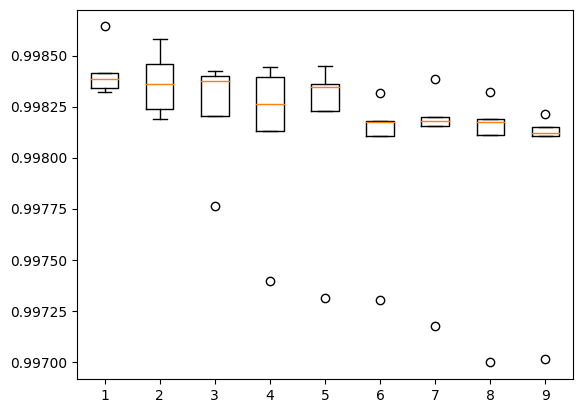

In [ ]:
grid={"min_samples_leaf":[i for i in range(1, 10)]}
model=tree.DecisionTreeRegressor()
results = grid_search(grid, model, x, y)
plotGridResults(results)

#### min_samples_split param

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START clf__min_samples_split=2..................................
[CV 1/10; 1/10] END ...clf__min_samples_split=2;, score=0.998 total time=   0.1s
[CV 2/10; 1/10] START clf__min_samples_split=2..................................
[CV 2/10; 1/10] END ...clf__min_samples_split=2;, score=0.999 total time=   0.1s
[CV 3/10; 1/10] START clf__min_samples_split=2..................................
[CV 3/10; 1/10] END ...clf__min_samples_split=2;, score=0.999 total time=   0.1s
[CV 4/10; 1/10] START clf__min_samples_split=2..................................
[CV 4/10; 1/10] END ...clf__min_samples_split=2;, score=0.998 total time=   0.1s
[CV 5/10; 1/10] START clf__min_samples_split=2..................................
[CV 5/10; 1/10] END ...clf__min_samples_split=2;, score=0.998 total time=   0.1s
[CV 6/10; 1/10] START clf__min_samples_split=2..................................
[CV 6/10; 1/10] END ...clf__min_samples_split=

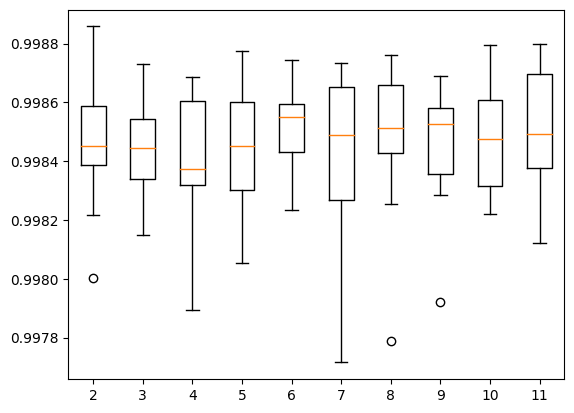

In [ ]:
grid={"min_samples_split":[i for i in range(2, 12)]}
model=tree.DecisionTreeRegressor()
results = grid_search(grid, model, x, y, cv=10)
plotGridResults(results)

I won't go into more analysis since we have better models than DT. In the following sections, I will also use squared_error because it is too long to calculate using absolute.

### Best decision tree eval

In [ ]:
treeModel = tree.DecisionTreeRegressor(criterion="absolute_error",
                                   max_depth=None,
                                   max_features=None,
                                   min_samples_leaf=1,
                                   min_samples_split=2)
model_cv_rapport(treeModel, x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.1s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s remaining:    8.0s


MAE:  108.2184
RMSE:  206.68085297
R2:  0.99844744


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


## Random forest

In [ ]:
model = ensemble.RandomForestRegressor(
    n_estimators=100,
    criterion="squared_error",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None #"sqrt", "log2", int, float
)
model.fit(x_train, y_train)
model_rapport("RF", model, y_test, x_test)

RF --------------------------------------
r2_score: 0.99921
mean squared error: 22354.73742
root mean squared error: 149.51501
mean absolute error: 83.40214


0.99921

### Hyperparameters - RF
Based on [this article](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/), for all RF based algorithms, I first need to pick a learning rate (except for RF), then the number of estimators, and then I can tune the tree parameters.

#### n_estimators param

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__n_estimators=10........................................
[CV 1/5; 1/6] END .........clf__n_estimators=10;, score=0.999 total time=   1.3s
[CV 2/5; 1/6] START clf__n_estimators=10........................................
[CV 2/5; 1/6] END .........clf__n_estimators=10;, score=0.999 total time=   1.5s
[CV 3/5; 1/6] START clf__n_estimators=10........................................
[CV 3/5; 1/6] END .........clf__n_estimators=10;, score=0.999 total time=   1.4s
[CV 4/5; 1/6] START clf__n_estimators=10........................................
[CV 4/5; 1/6] END .........clf__n_estimators=10;, score=0.999 total time=   0.9s
[CV 5/5; 1/6] START clf__n_estimators=10........................................
[CV 5/5; 1/6] END .........clf__n_estimators=10;, score=0.999 total time=   0.9s
[CV 1/5; 2/6] START clf__n_estimators=20........................................
[CV 1/5; 2/6] END .........clf__n_estimators=20;,

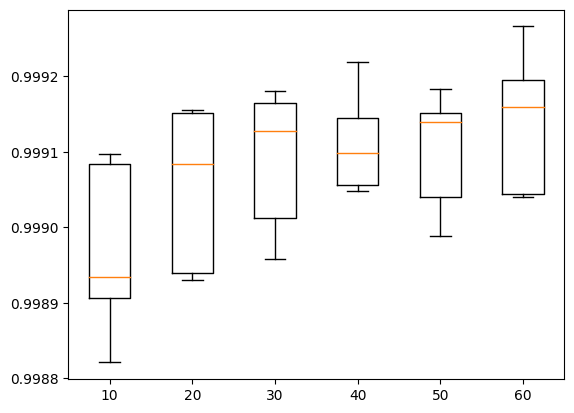

In [ ]:
grid={"n_estimators":[i*10 for i in range(1, 7)]}
model=ensemble.RandomForestRegressor()
results = grid_search(grid, model, x, y)
plotGridResults(results)

#### max_depth param

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START clf__max_depth=2...........................................
[CV 1/5; 1/10] END ............clf__max_depth=2;, score=0.908 total time=   1.1s
[CV 2/5; 1/10] START clf__max_depth=2...........................................
[CV 2/5; 1/10] END ............clf__max_depth=2;, score=0.911 total time=   1.3s
[CV 3/5; 1/10] START clf__max_depth=2...........................................
[CV 3/5; 1/10] END ............clf__max_depth=2;, score=0.911 total time=   1.7s
[CV 4/5; 1/10] START clf__max_depth=2...........................................
[CV 4/5; 1/10] END ............clf__max_depth=2;, score=0.915 total time=   0.8s
[CV 5/5; 1/10] START clf__max_depth=2...........................................
[CV 5/5; 1/10] END ............clf__max_depth=2;, score=0.917 total time=   0.8s
[CV 1/5; 2/10] START clf__max_depth=3...........................................
[CV 1/5; 2/10] END ............clf__max_depth=3;

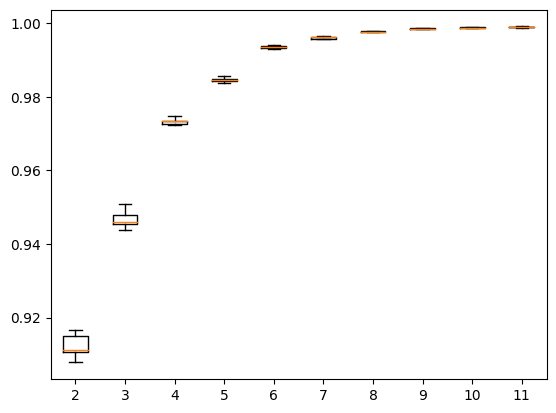

In [ ]:
grid={"max_depth":[i for i in range(2, 12)]}
model=ensemble.RandomForestRegressor(n_estimators=60)
results = grid_search(grid, model, x, y)
plotGridResults(results)

#### max_features param

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START clf__max_features=0.1......................................
[CV 1/5; 1/10] END .......clf__max_features=0.1;, score=0.997 total time=   1.3s
[CV 2/5; 1/10] START clf__max_features=0.1......................................
[CV 2/5; 1/10] END .......clf__max_features=0.1;, score=0.998 total time=   1.1s
[CV 3/5; 1/10] START clf__max_features=0.1......................................
[CV 3/5; 1/10] END .......clf__max_features=0.1;, score=0.997 total time=   1.7s
[CV 4/5; 1/10] START clf__max_features=0.1......................................
[CV 4/5; 1/10] END .......clf__max_features=0.1;, score=0.997 total time=   1.4s
[CV 5/5; 1/10] START clf__max_features=0.1......................................
[CV 5/5; 1/10] END .......clf__max_features=0.1;, score=0.997 total time=   0.9s
[CV 1/5; 2/10] START clf__max_features=0.2......................................
[CV 1/5; 2/10] END .......clf__max_features=0.2;

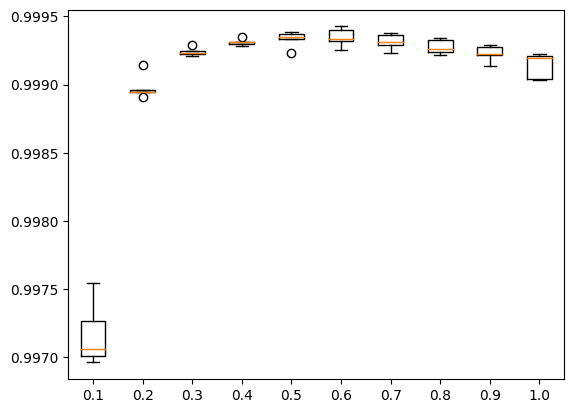

In [ ]:
grid={"max_features":[i/10.0 for i in range(1, 11)]}
model=ensemble.RandomForestRegressor(n_estimators=60)
results = grid_search(grid, model, x, y)
plotGridResults(results)

### Best RF eval

In [ ]:
model = ensemble.RandomForestRegressor(
    n_estimators=60,
    criterion="squared_error",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.6 #"sqrt", "log2", int, float
)
model_cv_rapport(model, x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.0s remaining:    6.0s


MAE:  80.29617167
RMSE:  137.78133939
R2:  0.99931444


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished


## Gradient Boosting

In [ ]:
model = ensemble.GradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.13,
    n_estimators=150,
    criterion="friedman_mse",
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=6,
    max_features=None,
    alpha=0.9
)
model.fit(x_train, y_train)
model_rapport("GB", model, y_test, x_test)

GB --------------------------------------
r2_score: 0.99927
mean squared error: 20814.78235
root mean squared error: 144.27329
mean absolute error: 90.29576


0.99927

### Hyperparameters - Gradient Boosting
#### learning_rate param

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START clf__learning_rate=0.05....................................
[CV 1/5; 1/15] END .....clf__learning_rate=0.05;, score=0.995 total time=   3.5s
[CV 2/5; 1/15] START clf__learning_rate=0.05....................................
[CV 2/5; 1/15] END .....clf__learning_rate=0.05;, score=0.995 total time=   3.7s
[CV 3/5; 1/15] START clf__learning_rate=0.05....................................
[CV 3/5; 1/15] END .....clf__learning_rate=0.05;, score=0.995 total time=   3.6s
[CV 4/5; 1/15] START clf__learning_rate=0.05....................................
[CV 4/5; 1/15] END .....clf__learning_rate=0.05;, score=0.995 total time=   3.7s
[CV 5/5; 1/15] START clf__learning_rate=0.05....................................
[CV 5/5; 1/15] END .....clf__learning_rate=0.05;, score=0.995 total time=   4.5s
[CV 1/5; 2/15] START clf__learning_rate=0.1.....................................
[CV 1/5; 2/15] END ......clf__learning_rate=0.1;

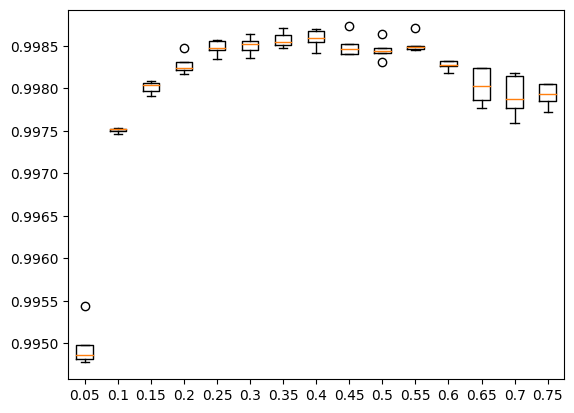

In [ ]:
grid={"learning_rate":[i*5/100.0 for i in range(1, 16)]}
model=ensemble.GradientBoostingRegressor()
results = grid_search(grid, model, x, y)
plotGridResults(results)

#### n_estimators param

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START clf__n_estimators=20.......................................
[CV 1/5; 1/16] END ........clf__n_estimators=20;, score=0.996 total time=   1.3s
[CV 2/5; 1/16] START clf__n_estimators=20.......................................
[CV 2/5; 1/16] END ........clf__n_estimators=20;, score=0.996 total time=   1.0s
[CV 3/5; 1/16] START clf__n_estimators=20.......................................
[CV 3/5; 1/16] END ........clf__n_estimators=20;, score=0.996 total time=   1.5s
[CV 4/5; 1/16] START clf__n_estimators=20.......................................
[CV 4/5; 1/16] END ........clf__n_estimators=20;, score=0.997 total time=   0.6s
[CV 5/5; 1/16] START clf__n_estimators=20.......................................
[CV 5/5; 1/16] END ........clf__n_estimators=20;, score=0.997 total time=   0.6s
[CV 1/5; 2/16] START clf__n_estimators=30.......................................
[CV 1/5; 2/16] END ........clf__n_estimators=30;

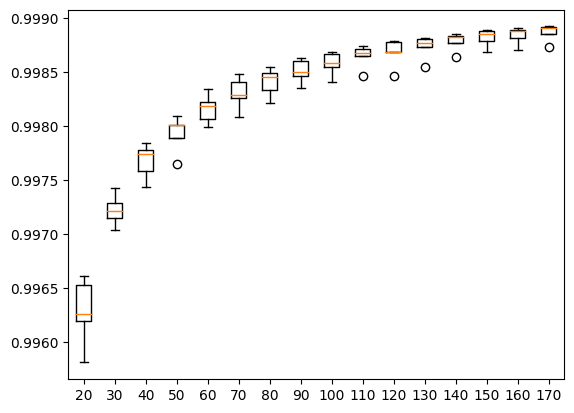

In [ ]:
grid={"n_estimators":[i*10 for i in range(2, 18)]}
model=ensemble.GradientBoostingRegressor(learning_rate=0.4)
results = grid_search(grid, model, x, y)
plotGridResults(results)

#### max_depth param

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START clf__max_depth=2...........................................
[CV 1/5; 1/10] END ............clf__max_depth=2;, score=0.998 total time=   5.0s
[CV 2/5; 1/10] START clf__max_depth=2...........................................
[CV 2/5; 1/10] END ............clf__max_depth=2;, score=0.998 total time=   5.1s
[CV 3/5; 1/10] START clf__max_depth=2...........................................
[CV 3/5; 1/10] END ............clf__max_depth=2;, score=0.998 total time=   4.5s
[CV 4/5; 1/10] START clf__max_depth=2...........................................
[CV 4/5; 1/10] END ............clf__max_depth=2;, score=0.998 total time=   4.9s
[CV 5/5; 1/10] START clf__max_depth=2...........................................
[CV 5/5; 1/10] END ............clf__max_depth=2;, score=0.998 total time=   7.7s
[CV 1/5; 2/10] START clf__max_depth=3...........................................
[CV 1/5; 2/10] END ............clf__max_depth=3;

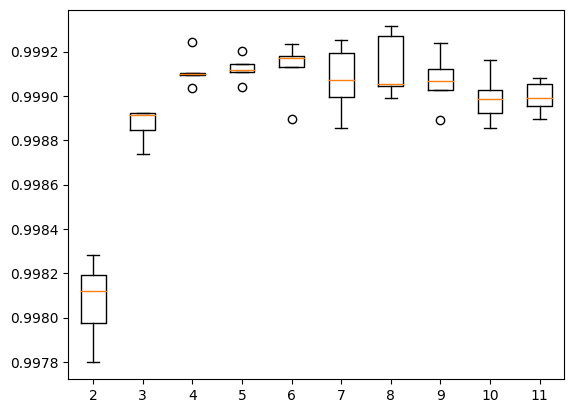

In [ ]:
grid={"max_depth":[i for i in range(2, 12)]}
model=ensemble.GradientBoostingRegressor(learning_rate=0.4, n_estimators=170)
results = grid_search(grid, model, x, y)
plotGridResults(results)

#### max_features param

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START clf__max_features=0.1......................................
[CV 1/5; 1/10] END .......clf__max_features=0.1;, score=0.989 total time=   0.5s
[CV 2/5; 1/10] START clf__max_features=0.1......................................
[CV 2/5; 1/10] END .......clf__max_features=0.1;, score=0.983 total time=   0.5s
[CV 3/5; 1/10] START clf__max_features=0.1......................................
[CV 3/5; 1/10] END .......clf__max_features=0.1;, score=0.990 total time=   0.5s
[CV 4/5; 1/10] START clf__max_features=0.1......................................
[CV 4/5; 1/10] END .......clf__max_features=0.1;, score=0.984 total time=   0.5s
[CV 5/5; 1/10] START clf__max_features=0.1......................................
[CV 5/5; 1/10] END .......clf__max_features=0.1;, score=0.995 total time=   0.5s
[CV 1/5; 2/10] START clf__max_features=0.2......................................
[CV 1/5; 2/10] END .......clf__max_features=0.2;

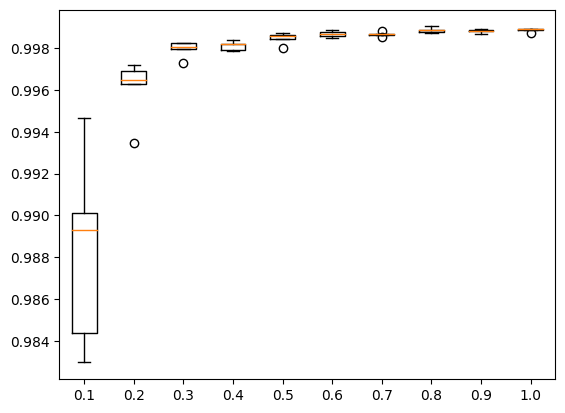

In [ ]:
grid={"max_features":[i/10.0 for i in range(1, 11)]}
model=ensemble.GradientBoostingRegressor(learning_rate=0.4, n_estimators=170)
results = grid_search(grid, model, x, y)
plotGridResults(results)

### Best Gradient Boosting eval

In [ ]:
model = ensemble.GradientBoostingRegressor(
    n_estimators=170,
    learning_rate=0.4,
    max_depth=8,
    max_features=None
)
model_cv_rapport(model, x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   27.0s remaining:   40.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   27.3s remaining:   18.2s


MAE:  91.57643515
RMSE:  156.17062066
R2:  0.99911477


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.7s finished


## XG Boosting

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor()
model.fit(x_train, y_train)
model_rapport("XGB", model, y_test, x_test)

XGB --------------------------------------
r2_score: 0.99925
mean squared error: 21193.85104
root mean squared error: 145.58108
mean absolute error: 94.65452


0.99925

### Hyperparameters - XG Boost
#### learning_rate param

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START clf__learning_rate=0.05....................................
[CV 1/5; 1/16] END .....clf__learning_rate=0.05;, score=0.998 total time=   0.7s
[CV 2/5; 1/16] START clf__learning_rate=0.05....................................
[CV 2/5; 1/16] END .....clf__learning_rate=0.05;, score=0.998 total time=   1.7s
[CV 3/5; 1/16] START clf__learning_rate=0.05....................................
[CV 3/5; 1/16] END .....clf__learning_rate=0.05;, score=0.998 total time=   1.2s
[CV 4/5; 1/16] START clf__learning_rate=0.05....................................
[CV 4/5; 1/16] END .....clf__learning_rate=0.05;, score=0.998 total time=   0.9s
[CV 5/5; 1/16] START clf__learning_rate=0.05....................................
[CV 5/5; 1/16] END .....clf__learning_rate=0.05;, score=0.998 total time=   0.9s
[CV 1/5; 2/16] START clf__learning_rate=0.1.....................................
[CV 1/5; 2/16] END ......clf__learning_rate=0.1;

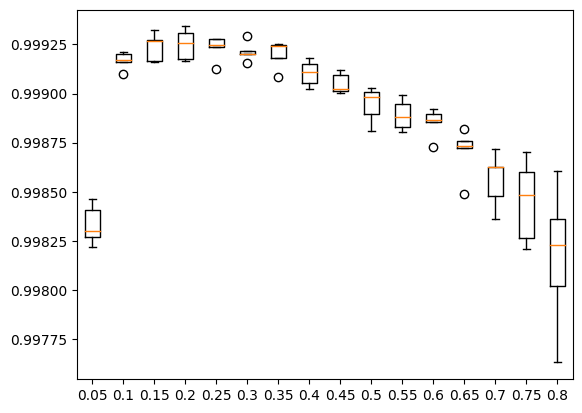

In [ ]:
grid={"learning_rate":[i*5/100.0 for i in range(1, 17)]}
model=XGBRegressor()
results = grid_search(grid, model, x, y)
plotGridResults(results)

#### n_estimators param

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START clf__n_estimators=30.......................................
[CV 1/5; 1/15] END ........clf__n_estimators=30;, score=0.999 total time=   0.9s
[CV 2/5; 1/15] START clf__n_estimators=30.......................................
[CV 2/5; 1/15] END ........clf__n_estimators=30;, score=0.999 total time=   0.3s
[CV 3/5; 1/15] START clf__n_estimators=30.......................................
[CV 3/5; 1/15] END ........clf__n_estimators=30;, score=0.999 total time=   0.4s
[CV 4/5; 1/15] START clf__n_estimators=30.......................................
[CV 4/5; 1/15] END ........clf__n_estimators=30;, score=0.999 total time=   0.4s
[CV 5/5; 1/15] START clf__n_estimators=30.......................................
[CV 5/5; 1/15] END ........clf__n_estimators=30;, score=0.999 total time=   0.4s
[CV 1/5; 2/15] START clf__n_estimators=40.......................................
[CV 1/5; 2/15] END ........clf__n_estimators=40;

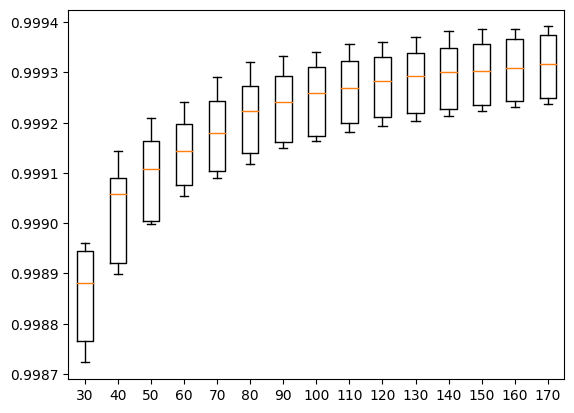

In [ ]:
grid={"n_estimators":[i*10 for i in range(3, 18)]}
model=XGBRegressor(learning_rate=0.2)
results = grid_search(grid, model, x, y)
plotGridResults(results)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START clf__n_estimators=150......................................
[CV 1/5; 1/10] END .......clf__n_estimators=150;, score=0.999 total time=   2.9s
[CV 2/5; 1/10] START clf__n_estimators=150......................................
[CV 2/5; 1/10] END .......clf__n_estimators=150;, score=0.999 total time=   3.0s
[CV 3/5; 1/10] START clf__n_estimators=150......................................
[CV 3/5; 1/10] END .......clf__n_estimators=150;, score=0.999 total time=   1.4s
[CV 4/5; 1/10] START clf__n_estimators=150......................................
[CV 4/5; 1/10] END .......clf__n_estimators=150;, score=0.999 total time=   1.3s
[CV 5/5; 1/10] START clf__n_estimators=150......................................
[CV 5/5; 1/10] END .......clf__n_estimators=150;, score=0.999 total time=   1.3s
[CV 1/5; 2/10] START clf__n_estimators=160......................................
[CV 1/5; 2/10] END .......clf__n_estimators=160;

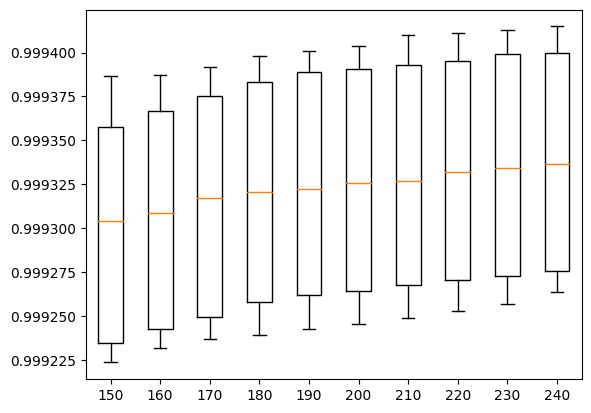

In [ ]:
grid={"n_estimators":[i*10 for i in range(15, 25)]}
model=XGBRegressor(learning_rate=0.2)
results = grid_search(grid, model, x, y)
plotGridResults(results)

#### max_depth param

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START clf__max_depth=2............................................
[CV 1/5; 1/9] END .............clf__max_depth=2;, score=0.998 total time=   1.7s
[CV 2/5; 1/9] START clf__max_depth=2............................................
[CV 2/5; 1/9] END .............clf__max_depth=2;, score=0.998 total time=   0.7s
[CV 3/5; 1/9] START clf__max_depth=2............................................
[CV 3/5; 1/9] END .............clf__max_depth=2;, score=0.998 total time=   0.5s
[CV 4/5; 1/9] START clf__max_depth=2............................................
[CV 4/5; 1/9] END .............clf__max_depth=2;, score=0.998 total time=   0.5s
[CV 5/5; 1/9] START clf__max_depth=2............................................
[CV 5/5; 1/9] END .............clf__max_depth=2;, score=0.998 total time=   0.5s
[CV 1/5; 2/9] START clf__max_depth=3............................................
[CV 1/5; 2/9] END .............clf__max_depth=3;,

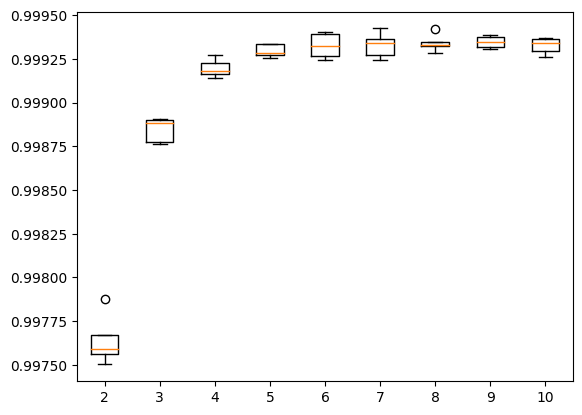

In [ ]:
grid={"max_depth":[i for i in range(2, 11)]}
model=XGBRegressor(learning_rate=0.2, n_estimators=200)
results = grid_search(grid, model, x, y)
plotGridResults(results)

### Best XG Boost eval

In [ ]:
#Best model
model = XGBRegressor(
    n_estimators=200,
    max_depth=9,
    learning_rate=0.2)

model_cv_rapport(model, x, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.8s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.2s remaining:   10.8s


MAE:  87.81217246
RMSE:  134.62632835
R2:  0.99934598


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.7s finished
